A general schematic of the amygdala network model for tone-shock conditioning is shown below. Our specific model has 12 cells with 8 PN, 2 PV, and 2 SOM cells. The network has background, tone, and shock connections.
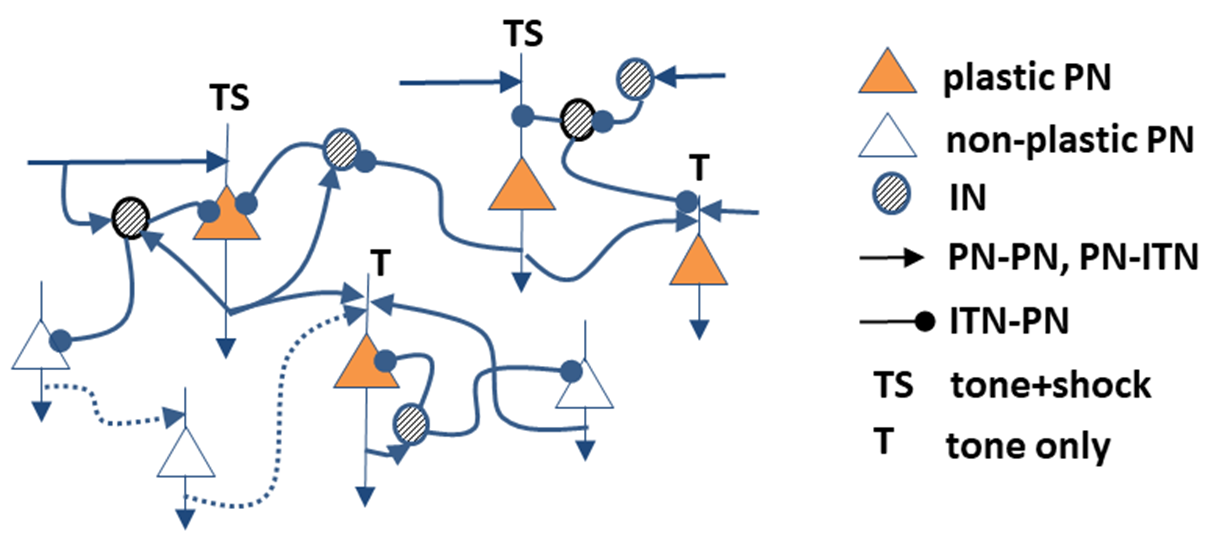

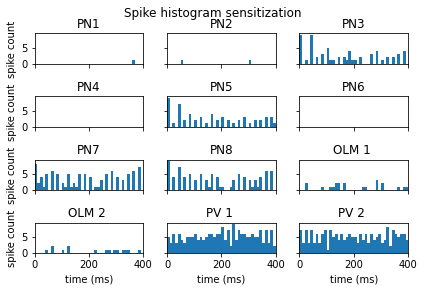

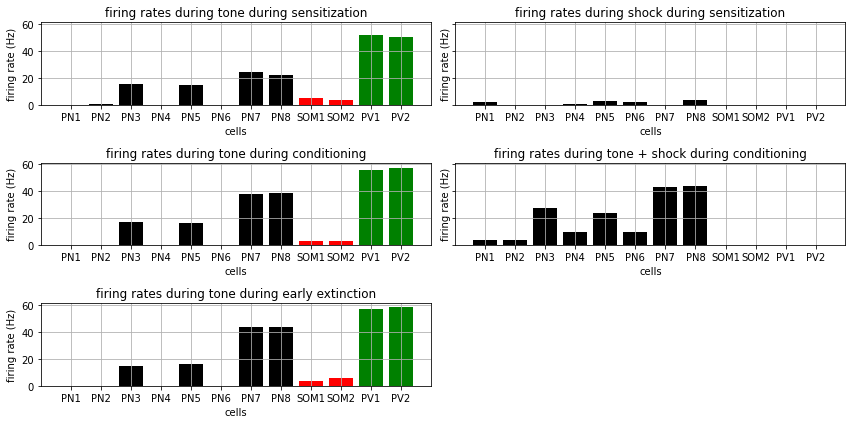

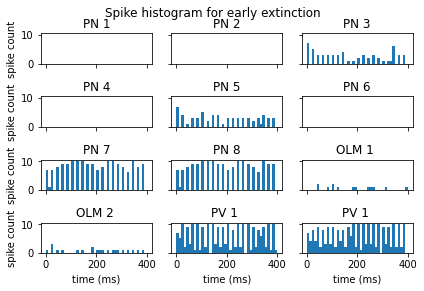

In [ ]:
#@title Run Cell to activate model
import os, sys
from io import StringIO
RunningInCOLAB = 'google.colab' in str(get_ipython())

print("Downloading model this will only take a min!")
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout
        
with Capturing() as output:
  if RunningInCOLAB:
      print('Downloading packages')
      !pip install NEURON==8.0.0
      !pip install bmtk==0.0.9
      !pip install ipywidgets==7.7.1

  if os.path.basename(os.getcwd())!='D4':
      !git clone https://github.com/GregGlickert/Fear-Lesson-Plans.git
      %cd Fear-Lesson-Plans/D4/biophys_components/mechanisms/
      !nrnivmodl modfiles
      %cd ../..
      %ls
      print("model was downloaded!")
  else:
      print("model was already downloaded")

from bmtk.builder import NetworkBuilder
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
from bmtk.utils.sim_setup import build_env_bionet
import numpy as np
import sys
import synapses
import random
import warnings

warnings.simplefilter(action='ignore', category=DeprecationWarning)

seed = 967
random.seed(seed)
np.random.seed(seed)

synapses.load()
syn = synapses.syn_params_dicts()

# Initialize our network

net = NetworkBuilder("biophysical")

num_inh = [1]

num_exc = [1]

##################################################################################
###################################BIOPHY#########################################

net.add_nodes(N=5, pop_name='PyrA',
              mem_potential='e',
              model_type='biophysical',
              model_template='hoc:Cell_A',
              morphology=None)

net.add_nodes(N=3, pop_name='PyrC',
              mem_potential='e',
              model_type='biophysical',
              model_template='hoc:Cell_C',
              morphology=None)
net.add_nodes(N=2, pop_name='OLM',
              mem_potential='e',
              model_type='biophysical',
              model_template='hoc:SOM_Cell_old',
              morphology=None)

net.add_nodes(N=2, pop_name='PV',
              mem_potential='e',
              model_type='biophysical',
              model_template='hoc:basket',
              morphology=None)

##################################################################################
###################################External Networks##############################

# print("Internal nodes built")

#print("making {} exc_stim nodes".format(np.sum(num_exc)))

# External excitatory inputs
tone = NetworkBuilder('tone')
tone.add_nodes(N=1,
               pop_name='tone',
               potential='exc',
               model_type='virtual')

#print("making {} inh_stim nodes".format(np.sum(num_inh)))
# External inhibitory inputs
shock = NetworkBuilder('shock')
shock.add_nodes(N=1,
                pop_name='shock',
                potential='exc',
                model_type='virtual')
#backgrounds
backgroundPN_A = NetworkBuilder('bg_pn_a')
backgroundPN_A.add_nodes(N=5,
                   pop_name='tON',
                   potential='exc',
                   model_type='virtual')

backgroundPN_C = NetworkBuilder('bg_pn_c')
backgroundPN_C.add_nodes(N=3,
                   pop_name='tON',
                   potential='exc',
                   model_type='virtual')

backgroundPV = NetworkBuilder('bg_pv')
backgroundPV.add_nodes(N=2,
                   pop_name='tON',
                   potential='exc',
                   model_type='virtual')

backgroundOLM = NetworkBuilder('bg_olm')
backgroundOLM.add_nodes(N=2,
                   pop_name='tON',
                   potential='exc',
                   model_type='virtual')



##################################################################################
###################################Edges##########################################

def one_to_all_shock2OLM(source, target):
    sid = source.node_id
    tid = target.node_id
    #print("connecting shock cell {} to OLM cell {}".format(sid, tid))
    return 1

def one_to_all_shock2PV(source, target):
    sid = source.node_id
    tid = target.node_id
    #print("connecting shock cell {} to PV cell {}".format(sid, tid))
    return 1

def shock2PN(source, target):
    sid = source.node_id
    tid = target.node_id
    if (tid == 0 or tid == 3 or tid == 4 or tid == 6 or tid==7):
        #print("connecting shock cell {} to PN {}".format(sid, tid))
        return 1
    else:
        return 0

def tone2PN(source, target):
    sid = source.node_id
    tid = target.node_id
    if (tid == 2 or tid == 4 or tid == 6 or tid == 7):
        #print("connecting tone cell {} to PN {}".format(sid, tid))
        tmp_nsyn = 1
    else:
        #print("not connecting{}".format(tid))
        tmp_nsyn = 0
    return tmp_nsyn

def tone2PV(source, target):
    sid = source.node_id
    tid = target.node_id
    #print("connecting tone cell {} to PV cell {}".format(sid, tid))
    return 1

def tone2OLM(source, target):
    sid = source.node_id
    tid = target.node_id
    #print("connecting tone cell {} to OLM cell {}".format(sid, tid))
    return 1

def PN2OLM(source, target):
    sid = source.node_id
    tid = target.node_id
    #print("connecting PN cell {} to OLM cell {}".format(sid, tid))
    return 1

def PN2PV(source, target):
    sid = source.node_id
    tid = target.node_id
    #print("connecting PN cell {} to PV cell {}".format(sid, tid))
    return 1

def PV2OLM(source, target):
    sid = source.node_id
    tid = target.node_id
    #print("connecting PV cell {} to OLM cell {}".format(sid, tid))
    return 1

def one_to_one(source, target):
    sid = source.node_id
    tid = target.node_id
    if sid == tid:
        #print("connecting cell {} to {}".format(sid, tid))
        tmp_nsyn = 1
    else:
        return 0

    return tmp_nsyn

def pyr_connection(source, target):
    sid = source.node_id
    tid = target.node_id
    if (sid != tid):
        #print("connecting PN cells {} and {}".format(sid, tid))
        return 1

def PV2PV(source, target):
    sid = source.node_id
    tid = target.node_id
    if (sid != tid):
        #print("connecting PV cell {} to PV {}".format(sid, tid))
        tmp_nsyn = 1
    else:
        return 0
    return tmp_nsyn

def PV2PN(source, target):
    sid = source.node_id
    tid = target.node_id
    #print("connecting PV cells {} to PN cell {}".format(sid, tid))
    return 3

def OLM2PN(source, target):
    sid = source.node_id
    tid = target.node_id
    #print("connecting OLM cells {} to PN cell {}".format(sid, tid))
    return 2

def BG_to_PN_A(source, target):
    sid = source.node_id
    tid = target.node_id
    if sid == tid:
        #print("connecting BG {} to PN_A{}".format(sid,tid))
        tmp_nsyn = 1
    else:
        return 0

    return tmp_nsyn

def BG_to_PN_C(source, target):
    sid = source.node_id
    tid = target.node_id
    tid = (tid-5)
    if sid == tid:
        #print("connecting BG {} to PN_C{}".format(sid,tid))
        tmp_nsyn = 1
    else:
        return 0

    return tmp_nsyn

def BG_to_PV(source, target):
    sid = source.node_id
    tid = target.node_id
    sid = sid + 10
    if sid == tid:
        #print("connecting BG {} to pv{}".format(sid,tid))
        tmp_nsyn = 1
    else:
        return 0

    return tmp_nsyn

def BG_to_OLM(source, target):
    sid = source.node_id
    tid = target.node_id
    sid = sid + 8
    if sid == tid:
        #print("connecting BG {} to olm{}".format(sid,tid))
        tmp_nsyn = 1
    else:
        return 0

    return tmp_nsyn

net.add_edges(source=shock.nodes(), target=net.nodes(pop_name='OLM'),
              connection_rule=one_to_all_shock2OLM,
              syn_weight=1.0,
              target_sections=['basal'],
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='shock2INT12.json',
              model_template=syn['shock2INT12.json']['level_of_detail'])

net.add_edges(source=shock.nodes(), target=net.nodes(pop_name='PV'),
              connection_rule=one_to_all_shock2PV,
              syn_weight=1.0,
              target_sections=['basal'],
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='shock2INT12.json',
              model_template=syn['shock2INT12.json']['level_of_detail'])


# Create connections between Tone --> Pyr cells
conn = net.add_edges(source=tone.nodes(), target=net.nodes(pop_name=['PyrA', 'PyrC']),
              connection_rule=tone2PN,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='tone2PN.json',
              model_template=syn['tone2PN.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(2, 0.9), dtypes=[np.int32, np.float]) # places syn on apic at 0.9

#net.add_edges(source=tone.nodes(), target=net.nodes(pop_name='OLM'),
#              connection_rule=tone2OLM,
#              syn_weight=3.0,
#              target_sections=['somatic'],
#              delay=0.1,
#              distance_range=[10.0, 11.0],
#              dynamics_params='tone2INT.json',
#              model_template=syn['tone2INT.json']['level_of_detail'])

conn = net.add_edges(source=tone.nodes(), target=net.nodes(pop_name='PV'),
              connection_rule=tone2PV,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='tone2INT.json',
              model_template=syn['tone2INT.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float]) # places syn on basal at 0.9

# Create connections between Pyr --> Pyr cells
conn = net.add_edges(source=net.nodes(pop_name='PyrA'), target=net.nodes(pop_name=['PyrA', 'PyrC']),
              connection_rule=pyr_connection,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='PN2PN.json',
              model_template=syn['PN2PN.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(2, 0.9), dtypes=[np.int32, np.float]) # places syn on apic at 0.9

conn = net.add_edges(source=net.nodes(pop_name='PyrC'), target=net.nodes(pop_name=['PyrA', 'PyrC']),
              connection_rule=pyr_connection,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='PN2PN.json',
              model_template=syn['PN2PN.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(2, 0.9), dtypes=[np.int32, np.float]) # places syn on apic at 0.9


conn = net.add_edges(source=net.nodes(pop_name=['PyrA', 'PyrC']), target=net.nodes(pop_name='OLM'),
              connection_rule=PN2OLM,
              syn_weight=1,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='PN2SOM.json',
              model_template=syn['PN2SOM.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float]) # places syn on basal at 0.9

# Create connections between Pyr --> PV cells
conn = net.add_edges(source=net.nodes(pop_name=['PyrA', 'PyrC']), target=net.nodes(pop_name='PV'),
              connection_rule=PN2PV,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='PN2PV.json',
              model_template=syn['PN2PV.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float]) # places syn on basal at 0.9


# Create connections Int --> Int cells

net.add_edges(source=net.nodes(pop_name='PV'), target=net.nodes(pop_name='PV'),
              connection_rule=PV2PV,
              syn_weight=1.0,
              target_sections=['somatic'],
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='PV2PV.json',
              model_template=syn['PV2PV.json']['level_of_detail'])

net.add_edges(source=net.nodes(pop_name='PV'), target=net.nodes(pop_name='OLM'),
              connection_rule=PV2OLM,
              syn_weight=1.0,
              target_sections=['somatic'],
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='PV2SOM.json',
              model_template=syn['PV2SOM.json']['level_of_detail'])

# Create connections Int --> Pyr cells
net.add_edges(source=net.nodes(pop_name='PV'), target=net.nodes(pop_name=['PyrA', 'PyrC']),
              connection_rule=PV2PN,
              syn_weight=1.0,
              target_sections=['somatic'],
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='PV2PN.json',
              model_template=syn['PV2PN.json']['level_of_detail'])

conn = net.add_edges(source=net.nodes(pop_name='OLM'), target=net.nodes(pop_name=['PyrA', 'PyrC']),
              connection_rule=OLM2PN,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='SOM2PN.json',
              model_template=syn['SOM2PN.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(2, 0.6), dtypes=[np.int32, np.float]) # places syn on apic at 0.6

conn = net.add_edges(source=backgroundPN_A.nodes(), target=net.nodes(pop_name='PyrA'),
              connection_rule=BG_to_PN_A,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='BG2PNA.json',
              model_template=syn['BG2PNA.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(2, 0.9), dtypes=[np.int32, np.float]) # places syn on apic at 0.9

conn = net.add_edges(source=backgroundPN_C.nodes(), target=net.nodes(pop_name='PyrC'),
              connection_rule=BG_to_PN_C,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='BG2PNC.json',
              model_template=syn['BG2PNC.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(2, 0.9), dtypes=[np.int32, np.float]) # places syn on apic at 0.9

conn = net.add_edges(source=backgroundOLM.nodes(), target=net.nodes(pop_name='OLM'),
              connection_rule=BG_to_OLM,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='BG2OLM.json',
              model_template=syn['BG2OLM.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float]) # places syn on basal at 0.9

conn = net.add_edges(source=backgroundPV.nodes(), target=net.nodes(pop_name='PV'),
              connection_rule=BG_to_PV,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='BG2PV.json',
              model_template=syn['BG2PV.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float]) # places syn on basal at 0.9

# Build and save our networks

net.build()
net.save(output_dir='network')

tone.build()
tone.save_nodes(output_dir='network')

shock.build()
shock.save_nodes(output_dir='network')

backgroundPN_A.build()
backgroundPN_A.save_nodes(output_dir='network')

backgroundPN_C.build()
backgroundPN_C.save_nodes(output_dir='network')

backgroundPV.build()
backgroundPV.save_nodes(output_dir='network')

backgroundOLM.build()
backgroundOLM.save_nodes(output_dir='network')

t_sim = 232500  # early extinction time is 232500 sensitization time is 40000
#print("stim time is set to %s" % t_sim)


#build_env_bionet(base_dir='./',
#                 network_dir='./network',
#                 tstop=t_sim, dt=0.1,
#                 report_vars=['v'],
#                 spikes_inputs=[('tone', './12_cell_inputs/tone_spikes.csv'),
#                                ('shock', './12_cell_inputs/shock_spikes.csv'),
#                                ('bg_pn', '12_cell_inputs/bg_pn_spikes.h5'),
#                                ('bg_pv', '12_cell_inputs/bg_pv_spikes.h5'),
#                                ('bg_olm', '12_cell_inputs/bg_olm_spikes.h5')],
#                 components_dir='biophys_components',
#                 config_file='config.json',
#                 compile_mechanisms=False)

psg = PoissonSpikeGenerator(population='tone')
psg.add(node_ids=range(1),  # need same number as cells
        firing_rate=2,    # 1 spike every 1 second Hz
        times=(0.0, t_sim/1000))  # time is in seconds for some reason
psg.to_sonata('12_cell_inputs/tone_background.h5')

#print('Number of background spikes for tone: {}'.format(psg.n_spikes()))

psg = PoissonSpikeGenerator(population='bg_pn_a')
psg.add(node_ids=range(5),  # need same number as cells
        firing_rate=6,    # 1 spike every 1 second Hz
        times=(0.0, t_sim/1000))  # time is in seconds for some reason
psg.to_sonata('12_cell_inputs/bg_pn_a_spikes.h5')

#print('Number of background spikes for PN_A: {}'.format(psg.n_spikes()))

psg = PoissonSpikeGenerator(population='bg_pn_c')
psg.add(node_ids=range(3),  # need same number as cells
        firing_rate=2,    # 1 spike every 1 second Hz
        times=(0.0, t_sim/1000))  # time is in seconds for some reason
psg.to_sonata('12_cell_inputs/bg_pn_c_spikes.h5')

#print('Number of background spikes for PN_C: {}'.format(psg.n_spikes()))


psg = PoissonSpikeGenerator(population='bg_pv')
psg.add(node_ids=range(2),  # need same number as cells
        firing_rate=7.7,    # 8 spikes every 1 second Hz
        times=(0.0, t_sim/1000))  # time is in seconds for some reason
psg.to_sonata('12_cell_inputs/bg_pv_spikes.h5')

#print('Number of background spikes for PV: {}'.format(psg.n_spikes()))

psg = PoissonSpikeGenerator(population='bg_olm')
psg.add(node_ids=range(2),  # need same number as cells
        firing_rate=8.5,    # 8 spikes every 1 second Hz
        times=(0.0, t_sim/1000))  # time is in seconds for some reason
psg.to_sonata('12_cell_inputs/bg_olm_spikes.h5')

#print('Number of background spikes for OLMM: {}'.format(psg.n_spikes()))

from bmtk.analyzer.spike_trains import to_dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


def generate_plots(path):
    f = h5py.File(path)
    df = pd.DataFrame(
        {'node_ids': f['spikes']['biophysical']['node_ids'], 'timestamps': f['spikes']['biophysical']['timestamps']})
    #df0 = df.loc[df['node_ids'] == 0]
    #df0.to_csv("spikes.csv")
    node_spike_array = []

    ##tone sense
    def tone_response(node_spike_array):
        node_num = 0

        while(node_num <= 11):
            df0 = df.loc[df['node_ids'] == node_num]

            x0 = df0['timestamps'].tolist()
            first_trial = []
            second_trial = []
            third_trial = []
            fourth_trial = []
            fifth_trial = []
            sixth_trial = []
            seventh_trial = []
            eighth_trial = []
            ninth_trial = []
            tenth_trial = []

            for i in range(len(x0)):
                if (x0[i] >= 0 and x0[i] <= 400):
                    first_trial.append(x0[i])
                if (x0[i] >= 4000 and x0[i] <= 4400):
                    second_trial.append(x0[i])
                if (x0[i] >= 8000 and x0[i] <= 8400):
                    third_trial.append(x0[i])
                if (x0[i] >= 12000 and x0[i] <= 12400):
                    fourth_trial.append(x0[i])
                if (x0[i] >= 16000 and x0[i] <= 16400):
                    fifth_trial.append(x0[i])
                if (x0[i] >= 20000 and x0[i] <= 20400):
                    sixth_trial.append(x0[i])
                if (x0[i] >= 24000 and x0[i] <= 24400):
                    seventh_trial.append(x0[i])
                if (x0[i] >= 28000 and x0[i] <= 28400):
                    eighth_trial.append(x0[i])
                if (x0[i] >= 32000 and x0[i] <= 32400):
                    ninth_trial.append(x0[i])
                if (x0[i] >= 36000 and x0[i] <= 36400):
                    tenth_trial.append(x0[i])

            for i in range(len(second_trial)):
                second_trial[i] -= 4000
            for i in range(len(third_trial)):
                third_trial[i] -= 8000
            for i in range(len(fourth_trial)):
                fourth_trial[i] -= 12000
            for i in range(len(fifth_trial)):
                fifth_trial[i] -= 16000
            for i in range(len(sixth_trial)):
                sixth_trial[i] -= 20000
            for i in range(len(seventh_trial)):
                seventh_trial[i] -= 24000
            for i in range(len(eighth_trial)):
                eighth_trial[i] -= 28000
            for i in range(len(ninth_trial)):
                ninth_trial[i] -= 32000
            for i in range(len(tenth_trial)):
                tenth_trial[i] -= 36000

            final_array = np.concatenate((first_trial, second_trial, third_trial, fourth_trial,
                                          fifth_trial, sixth_trial, seventh_trial, eighth_trial,
                                          ninth_trial, tenth_trial))

            node_spike_array.append(final_array)

            node_num = node_num+1

    def find_bins(array, width):
        try:
            minimmum = np.min(array)
            maximmum = np.max(array)
            bound_min = -1.0 * (minimmum % width - minimmum)
            bound_max = maximmum - maximmum % width + width
            n = int((bound_max - bound_min) / width) + 1
            bins = np.linspace(bound_min, bound_max, n)
        except:
            bins = 10
        return bins

    def set_up_graphs_sense():
        fig, axs = plt.subplots(4, 3, sharey=True, tight_layout=True, sharex=True)
        fig.suptitle('Spike histogram sensitization', y=1)

        i = 0
        column_cnt = 0
        row_cnt = 0

        while (i < 12):
            bins = find_bins(node_spike_array[i], 10)

            axs[row_cnt, column_cnt].hist(x=node_spike_array[i], bins=bins)
            axs[row_cnt, column_cnt].set_title('PN' + str(i + 1))
            if (i == 8):
                axs[row_cnt, column_cnt].set_title('OLM 1 ')
            if (i == 9):
                axs[row_cnt, column_cnt].set_title('OLM 2 ')
            if (i == 10):
                axs[row_cnt, column_cnt].set_title('PV 1 ')
            if (i == 11):
                axs[row_cnt, column_cnt].set_title('PV 2 ')
            # axs[row_cnt, column_cnt].ylabel("spikes")
            # axs[row_cnt, column_cnt].xlabel('ms')

            axs[row_cnt, column_cnt].set_xlim([0, 400])

            column_cnt = column_cnt + 1
            if (column_cnt > 2):
                column_cnt = 0
                row_cnt = row_cnt + 1

            i = i + 1

        plt.setp(axs[-1, :], xlabel='time (ms)')
        plt.setp(axs[:, 0], ylabel='spike count')
        plt.show()

    def spike_freq_bar_tone(axs):
        hz = []
        for i in range(12):
            hz.append(((len(node_spike_array[i]))/0.4)/10) # calculates firing rate in Hz
        x = [0,1,2,3,4,5,6,7,8,9,10,11]
        cells = ["PN1", "PN2", "PN3", "PN4", "PN5", "PN6", "PN7", "PN8", "SOM1", "SOM2", "PV1", "PV2"]
        axs.set_xticklabels(cells)
        axs.bar(height=hz,x=cells,color=['black', 'black', 'black', 'black', 'black', 'black','black', 'black',
                                          'red', 'red', 'green', 'green'])
        axs.set_title("firing rates during tone during sensitization")
        axs.set_xlabel("cells")
        axs.set_ylabel("firing rate (Hz)")
        axs.grid()
        return axs
        plt.show()

    #shock sense
    def shock_response(node_spike_array):
        node_num = 0

        while(node_num <= 11):
            df0 = df.loc[df['node_ids'] == node_num]

            x0 = df0['timestamps'].tolist()
            first_trial = []
            second_trial = []
            third_trial = []
            fourth_trial = []
            fifth_trial = []
            sixth_trial = []
            seventh_trial = []
            eighth_trial = []
            ninth_trial = []
            tenth_trial = []

            for i in range(len(x0)):
                if (x0[i] >= 1750 and x0[i] <= 1850):
                    first_trial.append(x0[i])
                if (x0[i] >= 5750 and x0[i] <= 5850):
                    second_trial.append(x0[i])
                if (x0[i] >= 9750 and x0[i] <= 9850):
                    third_trial.append(x0[i])
                if (x0[i] >= 13750 and x0[i] <= 13850):
                    fourth_trial.append(x0[i])
                if (x0[i] >= 17750 and x0[i] <= 17850):
                    fifth_trial.append(x0[i])
                if (x0[i] >= 21750 and x0[i] <= 21850):
                    sixth_trial.append(x0[i])
                if (x0[i] >= 25750 and x0[i] <= 25850):
                    seventh_trial.append(x0[i])
                if (x0[i] >= 29750 and x0[i] <= 29850):
                    eighth_trial.append(x0[i])
                if (x0[i] >= 33750 and x0[i] <= 33850):
                    ninth_trial.append(x0[i])
                if (x0[i] >= 37750 and x0[i] <= 37850):
                    tenth_trial.append(x0[i])
            """
            for i in range(len(second_trial)):
                second_trial[i] -= 5750
            for i in range(len(third_trial)):
                third_trial[i] -= 9750
            for i in range(len(fourth_trial)):
                fourth_trial[i] -= 13750
            for i in range(len(fifth_trial)):
                fifth_trial[i] -= 
            for i in range(len(sixth_trial)):
                sixth_trial[i] -= 25750
            for i in range(len(seventh_trial)):
                seventh_trial[i] -= 29750
            for i in range(len(eighth_trial)):
                eighth_trial[i] -= 33750
            for i in range(len(ninth_trial)):
                ninth_trial[i] -= 32000
            for i in range(len(tenth_trial)):
                tenth_trial[i] -= 36000
            """

            final_array = np.concatenate((first_trial, second_trial, third_trial, fourth_trial,
                                          fifth_trial, sixth_trial, seventh_trial, eighth_trial,
                                          ninth_trial, tenth_trial))

            node_spike_array.append(final_array)

            node_num = node_num+1

    def spike_freq_bar_shock(shock_response_arr, axes):
        hz = []
        for i in range(12):
            hz.append(((len(shock_response_arr[i]))/0.1)/10) # calculates firing rate in Hz

        #print(shock_response_arr[9])
        x = [0,1,2,3,4,5,6,7,8,9,10,11]
        cells = ["PN1", "PN2", "PN3", "PN4", "PN5", "PN6", "PN7", "PN8", "SOM1", "SOM2", "PV1", "PV2"]
        axes.set_xticklabels(cells)
        axes.bar(height=hz,x=cells,color=['black', 'black', 'black', 'black', 'black', 'black','black', 'black',
                                          'red', 'red', 'green', 'green'])
        axes.set_title("firing rates during shock during sensitization")
        axes.set_xlabel("cells")
        axes.set_ylabel("firing rate (Hz)")
        axes.grid()
        return axes


    ## tone during cond
    def tone_during_cond(node_spike_array, axes):
        total_spikes = []
        timestamp = 40000
        node_num = 0
        while(node_num <= 12):
            df0 = df.loc[df['node_ids'] == node_num]
            df0.sort_values(by=['timestamps'])
            x0 = df0['timestamps'].tolist()
            trial_spikes = []
            i = 0
            while(i < 10):
                for j in range(len(x0)):
                    if(x0[j] >= timestamp+(i*4000) and x0[j] <= timestamp+(i*4000+400)):
                        value = (x0[j]-(i*4000) - timestamp)
                        trial_spikes.append(value)

            #should go through all 30 trials and get every value and condense them
                i = i+1

            # should create a list of lists 12 of them each one being a node
            node_spike_array.append(trial_spikes)
            node_num = node_num+1

        hz = []
        for i in range(12):
            hz.append(((len(node_spike_array[i]))/0.4)/10) # calculates firing rate in Hz

        x = [0,1,2,3,4,5,6,7,8,9,10,11]
        cells = ["PN1", "PN2", "PN3", "PN4", "PN5", "PN6", "PN7", "PN8", "SOM1", "SOM2", "PV1", "PV2"]
        axes.set_xticklabels(cells)
        axes.bar(height=hz, x=cells, color=['black', 'black', 'black', 'black', 'black', 'black','black', 'black',
                                          'red', 'red', 'green', 'green'])
        axes.set_title("firing rates during tone during conditioning")
        axes.set_xlabel("cells")
        axes.set_ylabel("firing rate (Hz)")
        axes.grid()
        return axes

    def shock_during_cond(node_spike_array, axes):
        total_spikes = []
        timestamp = 40000
        node_num = 0
        while(node_num <= 12):
            df0 = df.loc[df['node_ids'] == node_num]
            df0.sort_values(by=['timestamps'])
            x0 = df0['timestamps'].tolist()
            trial_spikes = []
            i = 0
            while(i < 10):
                for j in range(len(x0)):
                    if(x0[j] >= timestamp+(i*4000+400) and x0[j] <= timestamp+(i*4000+500)):
                        value = (x0[j]-(i*4000) - timestamp)
                        trial_spikes.append(value)

            #should go through all 30 trials and get every value and condense them
                i = i+1

            # should create a list of lists 12 of them each one being a node
            node_spike_array.append(trial_spikes)
            node_num = node_num+1

        hz = []
        for i in range(12):
            hz.append(((len(node_spike_array[i]))/0.1)/10) # calculates firing rate in Hz

        x = [0,1,2,3,4,5,6,7,8,9,10,11]
        cells = ["PN1", "PN2", "PN3", "PN4", "PN5", "PN6", "PN7", "PN8", "SOM1", "SOM2", "PV1", "PV2"]
        axes.set_xticklabels(cells)
        axes.bar(height=hz, x=cells, color=['black', 'black', 'black', 'black', 'black', 'black','black', 'black',
                                          'red', 'red', 'green', 'green'])
        axes.set_title("firing rates during tone + shock during conditioning")
        axes.set_xlabel("cells")
        axes.set_ylabel("firing rate (Hz)")
        axes.grid()
        return axes


    def create_arrays_extinction_early(node_spike_array):
        total_spikes = []
        timestamp = 116000
        node_num = 0
        while(node_num <= 12):
            df0 = df.loc[df['node_ids'] == node_num]
            df0.sort_values(by=['timestamps'])
            x0 = df0['timestamps'].tolist()
            trial_spikes = []
            i = 0
            while(i < 10):
                for j in range(len(x0)):
                    if(x0[j] >= timestamp+(i*4000) and x0[j] <= timestamp+(i*4000+400)):
                        value = (x0[j]-(i*4000) - timestamp)
                        trial_spikes.append(value)

            #should go through all 30 trials and get every value and condense them
                i = i+1

            # should create a list of lists 12 of them each one being a node
            node_spike_array.append(trial_spikes)
            node_num = node_num+1
        #print(total_spikes)
        #node_spike_array = total_spikes
        #print(node_spike_array)

    def set_up_graphs_EE():
        fig, axs = plt.subplots(4, 3, sharey=True, tight_layout=True, sharex=True)
        fig.suptitle('Spike histogram for early extinction', y=1)

        i = 0
        column_cnt = 0
        row_cnt = 0

        while (i < 12):
            bins = find_bins(extinction_array[i], 10)

            axs[row_cnt, column_cnt].hist(x=extinction_array[i], bins=bins)
            axs[row_cnt, column_cnt].set_title('PN ' + str(i + 1))
            if (i == 8):
                axs[row_cnt, column_cnt].set_title('OLM 1 ')
            if (i == 9):
                axs[row_cnt, column_cnt].set_title('OLM 2 ')
            if (i == 10):
                axs[row_cnt, column_cnt].set_title('PV 1 ')
            if (i == 11):
                axs[row_cnt, column_cnt].set_title('PV 1 ')
            # axs[row_cnt, column_cnt].ylabel("spikes")
            # axs[row_cnt, column_cnt].xlabel('ms')

            # axs[row_cnt, column_cnt].set_xlim([0,400])

            column_cnt = column_cnt + 1
            if (column_cnt > 2):
                column_cnt = 0
                row_cnt = row_cnt + 1

            i = i + 1

        plt.setp(axs[-1, :], xlabel='time (ms)')
        plt.setp(axs[:, 0], ylabel='spike count')

    def tone_during_EE(spike_array, axs):
        hz = []
        #print(spike_array)
        for i in range(12):
            hz.append(((len(spike_array[i])) / 0.4) / 10)  # calculates firing rate in Hz
        x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        cells = ["PN1", "PN2", "PN3", "PN4", "PN5", "PN6", "PN7", "PN8", "SOM1", "SOM2", "PV1", "PV2"]
        axs.set_xticklabels(cells)
        axs.bar(height=hz, x=cells,color=['black', 'black', 'black', 'black', 'black', 'black','black', 'black',
                                          'red', 'red', 'green', 'green'])
        axs.set_title("firing rates during tone during early extinction")
        axs.set_xlabel("cells")
        axs.set_ylabel("firing rate (Hz)")
        axs.grid()
        return axs


    tone_response(node_spike_array)

    set_up_graphs_sense()
    fig, axs = plt.subplots(3,2, sharex=False,sharey=True, tight_layout=True, figsize=(12,6))
    spike_freq_bar_tone(axs[0,0])
    shock_arr = []
    shock_response(shock_arr)
    spike_freq_bar_shock(shock_arr, axs[0,1])
    tone_cond = []
    tone_during_cond(tone_cond, axs[1,0])
    shock_cond = []
    shock_during_cond(shock_cond, axs[1,1])
    fig.delaxes(axs[2][1])


    #EE stuff
    extinction_array = []
    create_arrays_extinction_early(extinction_array)
    tone_during_EE(extinction_array,axs[2,0])
    plt.show()
    set_up_graphs_EE()
    plt.show()

from ipywidgets import widgets, HBox, VBox
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
from IPython.display import clear_output
from IPython.utils import io
import os, sys
import json
from bmtk.simulator import bionet
import numpy as np
import warnings
import random
from io import StringIO
import synapses
from neuron import h

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

slider1 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="PN_input")
#Create your button.
button1 = widgets.Button(description="Generate")
output1 = widgets.Output()
slider2 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="PV_input")
#Create your button.
button2 = widgets.Button(description="Generate")
output2 = widgets.Output()
button3 = widgets.Button(description="run_model")

slider4 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="PN2PV")
#Create your button.
button4 = widgets.Button(description="Edit")
output4 = widgets.Output()

slider5 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="PV2PN")
#Create your button.
button5 = widgets.Button(description="Edit")
output5 = widgets.Output()

slider6 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="OLM_input")
#Create your button.
button6 = widgets.Button(description="Generate")
output6 = widgets.Output()

slider7 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="OLM2PN")
#Create your button.
button7 = widgets.Button(description="Edit")
output7 = widgets.Output()


#function to handle input.
def gen_bg_pn(btn):
    clear_output()
    output1.clear_output()
    return_value = slider1.value
    os.remove('3_cell_inputs/bg_pn_c_spikes.h5')
    if return_value != 0:
        psg = PoissonSpikeGenerator(population='bg_pn_c')
        psg.add(node_ids=range(1),  # need same number as cells
            firing_rate=return_value,    # 1 spike every 1 second Hz
            times=(0.0, 40000/1000))  # time is in seconds for some reason
        psg.to_sonata('3_cell_inputs/bg_pn_c_spikes.h5')
    else:
        psg = PoissonSpikeGenerator(population='bg_pn_c')
        psg.add(node_ids=range(1),  # need same number as cells
            firing_rate=0.00001,    # 1 spike every 1 second Hz
            times=(0.0, 40000/1000))  # time is in seconds for some reason
        psg.to_sonata('3_cell_inputs/bg_pn_c_spikes.h5')
    print('Generated background of PN at : {} Hz'.format(return_value))
    display(ui)
    #with output1:
        #print(return_value)
def gen_bg_pv(btn):
    clear_output()
    output2.clear_output()
    return_value = slider2.value
    os.remove('3_cell_inputs/bg_pv_spikes.h5')
    if return_value != 0:
        psg = PoissonSpikeGenerator(population='bg_pv')
        psg.add(node_ids=range(1),  # need same number as cells
            firing_rate=return_value,    # 1 spike every 1 second Hz
            times=(0.0, 40000/1000))  # time is in seconds for some reason
        psg.to_sonata('3_cell_inputs/bg_pv_spikes.h5')
    else:
        psg = PoissonSpikeGenerator(population='bg_pv')
        psg.add(node_ids=range(1),  # need same number as cells
            firing_rate=0.00001,    # 1 spike every 1 second Hz
            times=(0.0, 40000/1000))  # time is in seconds for some reason
        psg.to_sonata('3_cell_inputs/bg_pv_spikes.h5')
    print('Generated background of PV at : {} Hz'.format(return_value))
    display(ui)

def gen_bg_olm(btn):
    clear_output()
    output6.clear_output()
    return_value = slider6.value
    os.remove('3_cell_inputs/bg_olm_spikes.h5')
    if return_value != 0:
        psg = PoissonSpikeGenerator(population='bg_olm')
        psg.add(node_ids=range(1),  # need same number as cells
            firing_rate=return_value,    # 1 spike every 1 second Hz
            times=(0.0, 40000/1000))  # time is in seconds for some reason
        psg.to_sonata('3_cell_inputs/bg_olm_spikes.h5')
    else:
        psg = PoissonSpikeGenerator(population='bg_olm')
        psg.add(node_ids=range(1),  # need same number as cells
            firing_rate=0.000001,    # 1 spike every 1 second Hz
            times=(0.0, 40000/1000))  # time is in seconds for some reason
        psg.to_sonata('3_cell_inputs/bg_olm_spikes.h5')
    print('Generated background of OLM at : {} Hz'.format(return_value))
    display(ui)
    
def change_PN2PV(btn):
    clear_output()
    output4.clear_output()
    return_value = slider4.value
    with open('biophys_components/synaptic_models/PN2PV.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed PN2PV synaptic weight to {}".format(return_value))
    display(ui)
    

def change_PV2PN(btn):
    clear_output()
    output5.clear_output()
    return_value = slider5.value
    with open('biophys_components/synaptic_models/PV2PN.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed PV2PN synaptic weight to {}".format(return_value))
    display(ui)

def change_OLM2PN(btn):
    clear_output()
    output7.clear_output()
    return_value = slider7.value
    with open('biophys_components/synaptic_models/SOM2PN.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed SOM2PN synaptic weight to {}".format(return_value))
    display(ui)

button1.on_click(gen_bg_pn)
button2.on_click(gen_bg_pv)
button4.on_click(change_PN2PV)
button5.on_click(change_PV2PN)
button6.on_click(gen_bg_olm)
button7.on_click(change_OLM2PN)
##do the same thing but change the weight in the json file but opening it and changing it might be a bitch but idk how else
def run_model(*args):
    clear_output()
    with Capturing() as output:
        synapses.load()
        h.nrnmpi_init()
        pc = h.ParallelContext()  # object to access MPI methods
        MPI_size = int(pc.nhost())
        MPI_rank = int(pc.id())


        config_file = 'simulation_config.json'



        conf = bionet.Config.from_json(config_file, validate=True);
        conf.build_env();

        graph = bionet.BioNetwork.from_config(conf);
        sim = bionet.BioSimulator.from_config(conf, network=graph);

        cells = graph.get_local_cells();

        sim.run();

        pc.barrier();
        pc.gid_clear()
        pc.done()
    display(ui)
button3.on_click(run_model)

def change_tone2PN(btn):
    clear_output()
    output8.clear_output()
    return_value = slider8.value
    with open('biophys_components/synaptic_models/tone2PN.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed tone2PN synaptic weight to {}".format(return_value))
    display(ui)
    
def change_tone2INT(btn):
    clear_output()
    output9.clear_output()
    return_value = slider9.value
    with open('biophys_components/synaptic_models/tone2INT.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed tone2PV synaptic weight to {}".format(return_value))
    display(ui)
    
def change_Shock2INT(btn):
    clear_output()
    output9.clear_output()
    return_value = slider9.value
    with open('biophys_components/synaptic_models/shock2INT12.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = (return_value * 10) # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed tone2PV synaptic weight to {}".format(return_value))
    display(ui)

slider8 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="TONE2PN")
#Create your button.
button8 = widgets.Button(description="Edit")
output8 = widgets.Output()

slider9 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="TONE2PV")
#Create your button.
button9 = widgets.Button(description="Edit")
output9 = widgets.Output()

slider10 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="Shock")
#Create your button.
button10 = widgets.Button(description="Edit")
output10 = widgets.Output()

from ipywidgets import widgets, HBox, VBox
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import clear_output
from IPython.utils import io
import os, sys
import matplotlib.pyplot as plt

button11 = widgets.Button(description="plot baseline")
button12 = widgets.Button(description="increased INT2PN")
button13 = widgets.Button(description="increased PN2PN")
button14 = widgets.Button(description="decreased PV2PV")
button15 = widgets.Button(description="increased shock2INT")
button16 = widgets.Button(description="increased tone2PV")
ui =  VBox([ HBox([slider1, button1, slider2, button2, slider6, button6]),
            HBox([slider4,button4,slider5,button5, slider7, button7]),
            HBox([slider8,button8,slider9,button9,slider10,button10]),
           HBox([button11,button12,button13,button14,button15,button16]),button3])
display(ui)



def plot1(bnt):
    clear_output()
    generate_plots('baseline/spikes.h5')
    display(ui)

def plot2(bnt):
    clear_output()
    generate_plots('INT2PN5/spikes.h5')
    display(ui)

def plot3(bnt):
    clear_output()
    generate_plots('PN2PN5/spikes.h5')
    display(ui)

def plot4(bnt):
    clear_output()
    generate_plots('PV2PV1/spikes.h5')
    display(ui)

def plot5(bnt):
    clear_output()
    generate_plots('shockdoubled/spikes.h5')
    display(ui)

def plot6(bnt):
    clear_output()
    generate_plots('toneweightdouble/spikes.h5')
    display(ui)
    
button11.on_click(plot1)
button12.on_click(plot2)
button13.on_click(plot3)
button14.on_click(plot4)
button15.on_click(plot5)
button16.on_click(plot6)
